In [1]:
import requests, json, logging
from matplotlib import pyplot

In [2]:
import numpy as np, cv2, yaml

In [3]:
from PIL import Image, ImageDraw

In [4]:
from pprint import pprint as pp
import os

In [5]:
from skimage import io as skimage_io

In [6]:
import blob_access_client as bac 


In [7]:
def getConfig(fileName):
    '''
    Retrieve API key, project ID, published name
    '''
    yaml_input = open(fileName, "r")
    yaml2Json = yaml.safe_load(yaml_input)
    # with open(fileName, "r") as f:
    #     lines = f.readlines()
    #     f.close()
    return yaml2Json

In [8]:
def drawBoundingBox(img, x0, y0, x1, y1):
    
    rectangle_w = [(x0, y0), (x1, y1)]
    
    img_with_boundingBox = ImageDraw.Draw(img)
    
    img_with_boundingBox.rectangle(rectangle_w, fill=None, outline=(255,255,255), width=7)
    
    return img

In [9]:
def woundsDetect(predictionImageUrl, predictionUrl_nostore, predictionKey):
    '''
    Call Custom Vision to identify wounds in image
    '''
    
    params = "" # passed as part of url
    headers = {
        "Content-Type": predictionContentType_url,
        "Prediction-key": predictionKey,
        }
    body = {
        "url": predictionImageUrl,
    }
    try:
        result = requests.post(predictionUrl, headers = headers, json = body)
        return result
    except e:
        logging.CRITICAL("Cannot post image to Custom Vision")
            

In [10]:
#
# retrieve config
#

configJson = getConfig("./wounds.yml") 


In [11]:
from azure.storage.blob import ContainerClient 
from azure.storage.blob import BlobClient

blob_connection_string = configJson["storage_blob"]["azure_storage_blob_connection_string"]
container_name = configJson["storage_blob"]["blob_container"]
container_client = ContainerClient.from_connection_string(conn_str=blob_connection_string, container_name=container_name)


In [12]:
#
#  List and retrieve recently uploaded image locally for processing
#
recentBlob = bac.latestBlob_get(container_name)[0]
bac.blob_download(container_name, recentBlob)

'localTemp.jpg'

In [13]:
localFileName = "localTemp.jpg"
ndarray3D_rbg = skimage_io.imread(recentBlob)[:,:,:3]
pyplot.imsave(localFileName, ndarray3D_rbg)
imageInput_rbg = Image.fromarray(ndarray3D_rbg)


In [14]:
#
#  Load it back to blob storage for Custom Vision
#
recentBlob = bac.latestBlob_get(container_name)[0]
bac.blob_upload(container_name, localFileName, localFileName)
recentBlob = bac.latestBlob_get(container_name)[0]

In [15]:
predictionUrl = configJson["computer_vision"]["predict_url_url"]
predictionImageUrl = configJson["computer_vision"]["predict_image_url"]
predictionContentType_url = configJson["computer_vision"]["predict_url_content_type"]
predictionContentType_image = configJson["computer_vision"]["predict_image_content_type"]
predictionProjectId = configJson["computer_vision"]["project_id"]
predictionKey = configJson["computer_vision"]['key']
predictionUrl_nostore = "{}{}".format(predictionUrl, "/nostore")
predictionImageUrl_nostore = "{}{}".format(predictionImageUrl, "nostore")
azure_storage_blob_sas_url = configJson["storage_blob"]["azure_storage_blob_sas_url"]
azure_storage_blob_sas_sas = configJson["storage_blob"]["azure_storage_blob_sas_sas"]

inputImageUrl = azure_storage_blob_sas_url + recentBlob + azure_storage_blob_sas_sas


#
# Wounds Indentification - Azure Custom Vision
#

In [16]:
#
# send to Custom Vision to identify wounds
#

result2 = woundsDetect(inputImageUrl,predictionUrl,predictionKey)


In [17]:

w_bboxes = []
bboxes_found = len(result2.json()['predictions'])

for i in range(bboxes_found):
    w_bbox_prob = result2.json()['predictions'][i]['probability']
    if w_bbox_prob > 0.50:
        w_bbox_left   = result2.json()['predictions'][i]['boundingBox']['left']
        w_bbox_top    = result2.json()['predictions'][i]['boundingBox']['top']
        w_bbox_width  = result2.json()['predictions'][i]['boundingBox']['width']
        w_bbox_height = result2.json()['predictions'][i]['boundingBox']['height']
        w_bboxes.append((w_bbox_left, w_bbox_top, w_bbox_width, w_bbox_height, w_bbox_prob))


In [18]:
#
#  Crop the bounding box image
#

x0 = int(w_bboxes[0][0] * imageInput_rbg.width)
y0 = int(w_bboxes[0][1] * imageInput_rbg.height)
width  = int(w_bboxes[0][2] * imageInput_rbg.width)
height = int(w_bboxes[0][3] * imageInput_rbg.height)
x1 = x0 + width
y1 = y0 + height
imageInput_rbg_cropped = imageInput_rbg.crop((x0, y0, x1, y1))


#
# Color Analysis
#

In [19]:
def colorsPercent(pilImage_rgb, color, hsv_lower, hsv_upper):
    w_image_rgb = np.array(pilImage_rgb)
    image_hsv = cv2.cvtColor(w_image_rgb, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(image_hsv, hsv_lower, hsv_upper)
    image_filtered_rgb = cv2.bitwise_and(w_image_rgb, w_image_rgb, mask=mask)
    color_on = cv2.countNonZero(mask)
    return color_on, image_hsv, image_filtered_rgb, mask
    

# 
# Color yellow: 50-60 degrees , <47% black , 0-100% luminence
#

In [20]:
color = "yellow"
hsv_lower = np.array([25, 0, 0])
hsv_upper = np.array([30, 120, 255])

color_count, image_hsv, image_filtered_rgby, masky = colorsPercent(imageInput_rbg_cropped, color, hsv_lower, hsv_upper )
color_percent = float(color_count)*100/(width * height)
logging.info("HSV: Color {} count: {}".format(color, color_count))
logging.info("HSV: Color {} : {}, total : {}, percent : {}%".format(color, color_count, (width * height), color_percent))

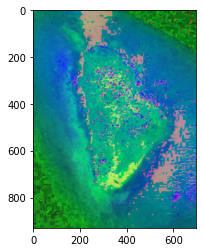

In [21]:
pyplot.imshow(image_hsv)

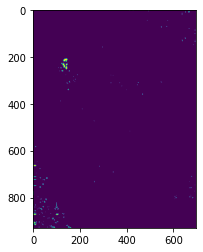

In [22]:
pyplot.imshow(masky)

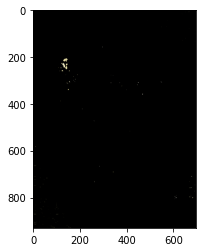

In [23]:
pyplot.imshow(image_filtered_rgby)

#
# Color black: all colors , >43% black , 0-20% luminence
#

In [24]:
color = "black"
hsv_lower = np.array([0, 110, 0])
hsv_upper = np.array([179, 255, 50])

color_count, image_hsv, image_filtered_rgbb, maskb = colorsPercent(imageInput_rbg_cropped, color, hsv_lower, hsv_upper )
color_percent = float(color_count)*100/(width * height)
print("HSV: Color {} count: {}".format(color, color_count))
print("HSV: Color {} : {}, total : {}, percent : {}%".format(color, color_count, (width * height), color_percent))

HSV: Color black count: 57165
HSV: Color black : 57165, total : 648210, percent : 8.818901281991947%


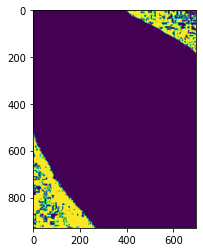

In [25]:
pyplot.imshow(maskb)

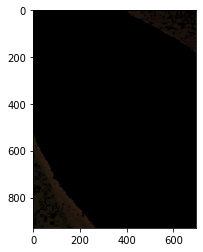

In [26]:
pyplot.imshow(image_filtered_rgbb)

# 
# Color red: 0- 20 degrees , <43% black , >43% luminence
#

In [27]:
color = "red"
hsv_lower = np.array([0, 0, 120])
hsv_upper = np.array([10, 110, 255])

color_count, image_hsv, image_filtered_rgbr, maskr = colorsPercent(imageInput_rbg_cropped, color, hsv_lower, hsv_upper )
color_percent = float(color_count)*100/(width * height)
print("HSV: Color {} count: {}".format(color, color_count))
print("HSV: Color {} : {}, total : {}, percent : {:0.2f}%".format(color, color_count, (width * height), color_percent))

HSV: Color red count: 74335
HSV: Color red : 74335, total : 648210, percent : 11.47%


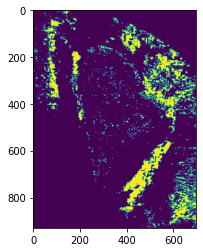

In [28]:
pyplot.imshow(maskr)

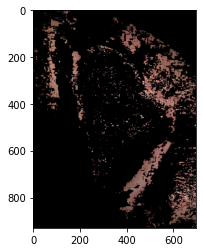

In [29]:
pyplot.imshow(image_filtered_rgbr)

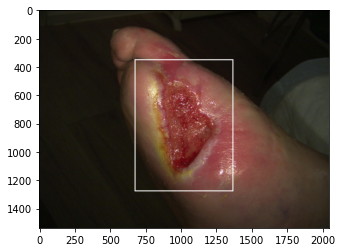

In [30]:
#
# Show original image with bounding boxes from Custom Vision
#
imageInput_bb = drawBoundingBox(imageInput_rbg, x0, y0, x1, y1)
pyplot.imshow(imageInput_bb)

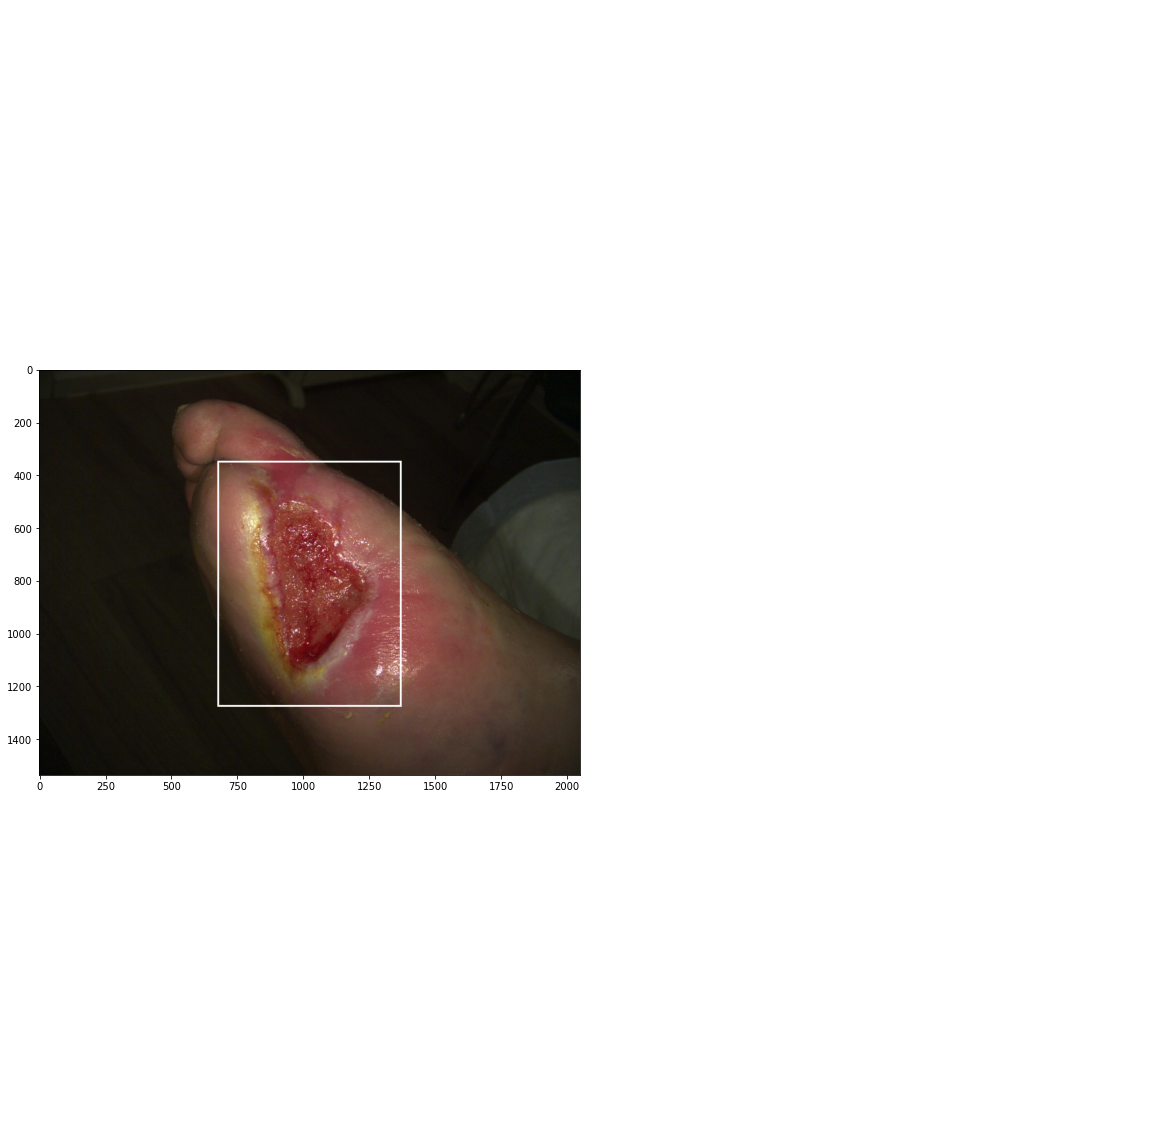

In [31]:
fig, axs = pyplot.subplots(1, 2, figsize=(16,16))
pyplot.tight_layout(pad=0.0, w_pad=1.0, h_pad=0.0)
axs[1].axis("off")
axs[0].imshow(imageInput_bb)

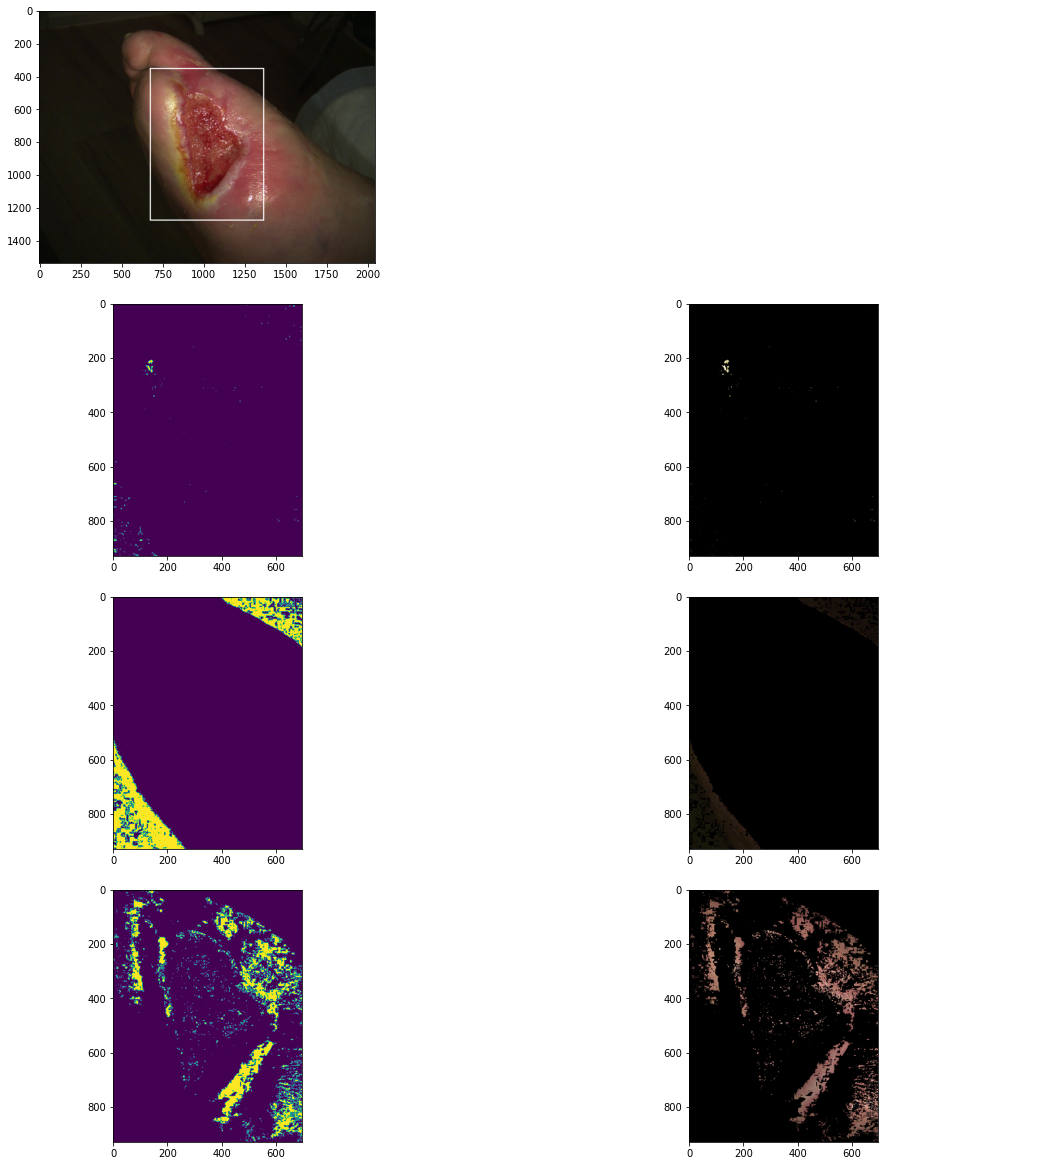

In [32]:
fig, axs = pyplot.subplots(4,2, figsize=(16,16))
pyplot.tight_layout(pad=0.0, w_pad=0.0, h_pad=2.0)
axs[0,0].imshow(imageInput_bb)
axs[0,1].axis("off")

axs[1,0].imshow(masky)
axs[1,1].imshow(image_filtered_rgby)

axs[2,0].imshow(maskb)
axs[2,1].imshow(image_filtered_rgbb)

axs[3,0].imshow(maskr)
axs[3,1].imshow(image_filtered_rgbr)


In [33]:
fig.savefig("final_fig.jpg", dpi=300)

In [34]:

bac.blob_upload("web", "final_fig.jpg", "final_fig.jpg")